# Annalysis

### Importing stuff

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import sys 
import scipy as sp

sys.path.append(os.path.join(os.getcwd(), '..'))
from facemap_tools.process_tools import *
import facemap_tools.plot_utils
from facemap_tools.plotting import plot_area
import facemap

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Loading procs

In [ ]:
# resultfolder = "/Volumes/T7/ING71_MEC_230309/AVI/resultsnpy" 
resultfolder = "/Users/annapaulinehjertvikaasen/Documents/2. UiO/Sommerjobb - Frederik/Sommerjobb 2023/MouseProject/ING71_MEC_230309/AVI/resultsnpy"

procs = create_procs(resultfolder)

### Loading behavioral data

In [ ]:
#Behavioral data

def get_experiment_n_day_k(n, k):
    #n is a string ex: '04', '10'
    #k is on the form yymmdd
    base = "/Volumes/T7/ING71_MEC_" + str(k)
    base = os.path.join(base, 'AVI')
    base = os.path.join(base, 'resultsnpy')

    behavior_base = "/Volumes/T7/mec-lec-por-data"
    files = os.listdir(base)

    experiment_base = 'ING71_MEC_' + str(k) + '_0' + n

    exp_filenames = [file for file in files if file[:20] == experiment_base]

    complete_proc = []
    for file in exp_filenames:
        proc = np.load(os.path.join(base, file), allow_pickle=True).item()
        complete_proc.extend(proc['pupil'][0]['area'])

    negative = np.load(os.path.join(behavior_base, experiment_base + '_negative.npy'), allow_pickle=True)
    positive = np.load(os.path.join(behavior_base, experiment_base + '_positive.npy'), allow_pickle=True)
    reward = np.load(os.path.join(behavior_base, experiment_base + '_reward.npy'), allow_pickle=True)
    aversive = np.load(os.path.join(behavior_base, experiment_base + '_aversive.npy'), allow_pickle=True)
    
    return complete_proc, negative, positive, reward, aversive


# c_proc, negative ,positive, reward, aversive = get_experiment_n_day_k('03', 230309)

In [ ]:
def get_behav_data(n, k):
    #n is a string ex: '04', '10'
    #k is on the form yymmdd

    base = "/Volumes/T7/ING71_MEC_" + str(k)
    base = os.path.join(base, 'AVI')
    base = os.path.join(base, 'resultsnpy')

    behavior_base = "/Volumes/T7/mec-lec-por-data"
    files = os.listdir(base)

    experiment_base = 'ING71_MEC_' + str(k) + '_0' + n

    negative = np.load(os.path.join(behavior_base, experiment_base + '_negative.npy'), allow_pickle=True)
    positive = np.load(os.path.join(behavior_base, experiment_base + '_positive.npy'), allow_pickle=True)
    reward = np.load(os.path.join(behavior_base, experiment_base + '_reward.npy'), allow_pickle=True)
    aversive = np.load(os.path.join(behavior_base, experiment_base + '_aversive.npy'), allow_pickle=True)

    behav = {}
    behav['negative'] = negative; behav['positive'] = positive; behav['reward'] = reward; behav['aversive'] = aversive 

    return behav

### Looking into pupil area plotted 

In [ ]:
for filename in list(procs.keys())[::5]:
    proc = procs[filename]
    plot_area(proc)
    plot_area(proc, zoom=True)


In [ ]:
proc = list(procs.values())[-1]

plt.plot(proc['pupil'][0]['area'])
plt.plot(proc['pupil'][0]['area_smooth'])
plt.xlim((500,800))

In [ ]:
print(procs.keys())

In [ ]:
plt.plot(procs['ING71_MEC_230309_001_Behav_Fr1-11947_proc']['pupil'][0]['area'])
plt.plot(procs['ING71_MEC_230309_001_Behav_Fr1-11947_proc']['pupil'][0]['area_smooth'])
# plt.xlim((500,800))
# plt.ylim((100,125))

### More interesting data?

In [ ]:
proc = list(procs.values())[0]

print(proc.keys())
print(proc['pupil'][0].keys())

print(np.shape(proc['pupil'][0]['axdir']))
print(np.shape(proc['pupil'][0]['axlen']))
# print(proc['pupil'][0]['axdir'])
# print(proc['pupil'][0]['axlen'])

In [ ]:
plt.plot(proc['pupil'][0]['axlen'][:,0])
plt.plot(proc['pupil'][0]['axlen'][:,1])

Looks like axlen and axdir refer to the axis that make up the tracker ellipse around the pupil. They seem to coincide very well with the area, which is expected as the area is calculated from the ellipse. We assume that axdir is the direction of the two axis making up the ellipse, and axlen the length of them. 

In [ ]:
print(proc['rois'][0].keys())

Looks like rois contain little data of interest for further analysis. It could be interesting for understanding what we have done when creating the ROIs, so one could argue that the proc-files (per folder, as the ROI is the same for an entire folder. Could call it sample or something) should be saved. 

In [ ]:
# 'Ly', 'Lx' 
print(proc['Lx'])
print(proc['Ly'])
print(86/3*66/3)

We assume the pupil makes up about 1/3 of the x-dir and y-dir. We see that the number of pixels within this fram seem to correspond with the y-axis of the area plots. 

When trying with two different files (within the same folder). Lx and Ly stay constant

In [ ]:
# 'avgframe':  list of average frames for each video from a subset of frames (binned by sbin) 
# 'avgmotion':  list of average motions for each video from a subset of frames (binned by sbin)
print(np.shape(proc['avgframe']))
print(proc['avgframe'])
plt.plot(proc['avgframe'][0])

In [ ]:
print(np.shape(proc['avgmotion']))
print(proc['avgmotion'])
plt.plot(proc['avgmotion'][0])

### Downsampling 

In [ ]:
c_proc, negative ,positive, reward, aversive = get_experiment_n_day_k('03', 230309)

In [ ]:
n_points = len(positive)
ds_proc = sp.signal.resample(c_proc, n_points) #ds stands for downsampled

plt.plot(ds_proc)
plt.plot(c_proc)
plt.show()

#Plot with downsampeled 
plt.plot(ds_proc)
plt.scatter(np.arange(len(positive)), positive*ds_proc, 5, color='r')
# plt.xlim(0,100)

In [ ]:

# Using decimate

ds_proc_d  = sp.signal.decimate(c_proc, 2)
 
plt.plot(ds_proc_d)
plt.plot(c_proc)
plt.show()

### Checking various ROIs for processing

Want to check the difference of creating one sampl.npy-file per folder (general) and compare with the results from creating one per video (individual). Starting with folder /Volumes/T7/ING71_MEC_230309/AVI. 

In [ ]:
# Loading general:
resultfolder_general = '/Volumes/T7/ING71_MEC_230309/AVI/resultsnpy' 
procs_general = create_procs(resultfolder_general)


In [ ]:
# Loading individuals and comparing:

proc_001_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_001_Behav_Fr1-11947_proc.npy', allow_pickle=True).item()
proc_001_gen = procs_general['ING71_MEC_230309_001_Behav_Fr1-11947_proc']

plot_area(proc_001_gen, show=False)
plot_area(proc_001_ind)


proc_002_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_002_Behav_Fr11949-23896_proc.npy', allow_pickle=True).item()
proc_002_gen = procs_general['ING71_MEC_230309_002_Behav_Fr11949-23896_proc']

plot_area(proc_002_gen, show=False)
plot_area(proc_002_ind)


proc_003_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_003_Behav_Fr23897-35844_proc.npy', allow_pickle=True).item()
proc_003_gen = procs_general['ING71_MEC_230309_003_Behav_Fr23897-35844_proc']

plot_area(proc_003_gen, show=False)
plot_area(proc_003_ind)


proc_009_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_009_Behav_Fr47793-59740_proc.npy', allow_pickle=True).item()
proc_009_gen = procs_general['ING71_MEC_230309_009_Behav_Fr47793-59740_proc']

plot_area(proc_009_gen, show=False)
plot_area(proc_009_ind)

Looks like the shape is kept rather constant although the absolute value seems to vary some. One can assume that some of this is due to the individual altering of saturation being better than the general one. Seems like the pupil is mostly within the defined region.  

In [ ]:

# Checkin the original one (should overlap completely):
proc_000_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_000_Behav_Fr1-9973_proc_wrong.npy', allow_pickle=True).item()
proc_000_gen = procs_general['ING71_MEC_230309_000_Behav_Fr1-9973_proc']

plot_area(proc_000_gen, show=False)
plot_area(proc_000_ind)

This is interesting! Not even the original one overlaps completely... Here the .npy-file was first processed in the GUI (yielding the green graph) and then that proc-file was used to process the entire folder (including the purple graph). Could it be that there is some randomness to the calculations which yield the difference in result? This was very interesting, indeed. Could it be that the saturation is not saved in the proc-file which is used for processing, but only employed when processing inside the GUI? This could be checked out 

#### Compare procs

In [ ]:
print(proc_000_gen['rois'][0]['saturation'])
print(proc_000_ind['rois'][0]['saturation'])

Very interesting... It seems the saturation is different in the two 

In [ ]:
print(proc_000_gen['rois'][0]['yrange'])
print(proc_000_ind['rois'][0]['yrange'])

print(proc_000_gen['rois'][0]['xrange'])
print(proc_000_ind['rois'][0]['xrange'])

In [ ]:
print(proc_000_gen['rois'][0]['ellipse'])
print(proc_000_ind['rois'][0]['ellipse'])

In [ ]:
plt.imshow(proc_000_ind['rois'][0]['ellipse'], cmap='plasma')
plt.imshow(proc_000_gen['rois'][0]['ellipse'], alpha=0.7, cmap='plasma')
plt.show()

See that there is not a complete overlap between the two. 

##### Compare procs for '/Volumes/T7/ING71_MEC_230317'
Would like to compare proc before and after processing (through facemap_tools)

Now with folder '/Volumes/T7/ING71_MEC_230317' (would have liked to try with the other mouse, but this is the only data I have access to at the moment.)

In [ ]:
proc_b4_proc = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_000_Behav_Fr1-9973_unproc_proc.npy', allow_pickle=True).item()
proc_af_proc = np.load('/Volumes/T7/ING71_MEC_230317/AVI/resultsnpy/ING71_MEC_230317_000_Behav_Fr1-9973_proc.npy', allow_pickle=True).item()

print(proc_b4_proc['rois'])
print(proc_af_proc['rois'])

Seem to be identical! 

Would now like to process it trough the gui and compare it. 

In [ ]:
proc_af_gui_proc = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_000_Behav_Fr1-9973_proc.npy', allow_pickle=True).item()

print(proc_b4_proc['rois'])
print(proc_af_gui_proc['rois'])

What? This still seem identical...

In [ ]:
plot_area(proc_af_proc, show=False)
plot_area(proc_af_gui_proc)

Wait, so now it completely overlaps... What did I do before? Haha.

Perhaps I sent in the  wrong npy-file while processing the folder? Perhaps I sent in the wrong path and it ended up using sample or something?

In [ ]:
# Look at sample.npy to see if this is the one who's been used 
proc_sample = np.load('/Users/annapaulinehjertvikaasen/Documents/2. UiO/Sommerjobb - Frederik/Sommerjobb 2023/MouseProject/MouseProjectGH/ING71_MEC_230309/AVI/sample.npy', allow_pickle=True).item()
print(proc_sample['rois'][0]['saturation'])

In [ ]:
proc_sample_2 = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_sample.npy', allow_pickle=True).item()
print(proc_sample_2['rois'][0]['saturation'])

Aha! Here we see what's happened! I have perhaps forgotten to send in the a path to the proc-file. 

However, when looking at the terminal history, this is not what happened. Looks like it should have used the path I sent in, also when looking at the function. 

![](figures/terminal.png)

To test this hypothesis though, we could process the ---_sample.npy file and compare. Should then see a complete overlap. If this is the case then the results above are valid. 


However, I cannot upload ---_sample.npy to the GUI since Eirik created that, hahah.


#### Next folder: '/Volumes/T7/ING71_MEC_230317'

In [ ]:
procs_17_general = create_procs('/Volumes/T7/ING71_MEC_230317/AVI/resultsnpy')

In [ ]:
proc_17_001_ind = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_001_Behav_Fr1-11947_proc.npy', allow_pickle=True).item()
proc_17_001_gen = procs_17_general['ING71_MEC_230317_001_Behav_Fr1-11947_proc']

plot_area(proc_17_001_gen, show=False)
plot_area(proc_17_001_ind)


proc_17_002_ind = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_002_Behav_Fr11949-23896_proc.npy', allow_pickle=True).item()
proc_17_002_gen = procs_17_general['ING71_MEC_230317_002_Behav_Fr11949-23896_proc']

plot_area(proc_17_002_gen, show=False)
plot_area(proc_17_002_ind)


proc_17_003_ind = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_003_Behav_Fr23897-35844_proc.npy', allow_pickle=True).item()
proc_17_003_gen = procs_17_general['ING71_MEC_230317_003_Behav_Fr23897-35844_proc']

plot_area(proc_17_003_gen, show=False)
plot_area(proc_17_003_ind, alpha=0.65)


proc_17_009_ind = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_009_Behav_Fr47793-59738_proc.npy', allow_pickle=True).item()
proc_17_009_gen = procs_17_general['ING71_MEC_230317_009_Behav_Fr47793-59738_proc']

plot_area(proc_17_009_gen, show=False)
plot_area(proc_17_009_ind, alpha=0.65)

Again it looks like the general shape of the area stays constant. In most cases there seems to be a shift, perhaps due to the saturation settings.

### Compare area and area smooth (Runwise)

In [ ]:
areas, areas_smooth = create_areas('/Volumes/T7/ING71_MEC_230317/AVI/resultsnpy/run_based')

In [ ]:
plt.plot(areas['000'])
plt.plot(areas_smooth['000'], alpha=0.65)

Looks like 'area smooth' differs from 'area' quite alot, even though the general shape of the signal is the same. However, I find it very strange that 'amooth' has some "blinking" that area does not have...

In [ ]:
plt.plot(areas['001'])
plt.plot(areas_smooth['001'], alpha=0.65)

Looks like the 'area smooth' overlaps rather well with the 'area' in this

In [ ]:
plt.plot(areas['002'])
plt.plot(areas_smooth['002'], alpha=0.65)

In [ ]:
plt.plot(areas['003'])
plt.plot(areas_smooth['003'], alpha=0.65)

In [ ]:
plt.plot(areas['009'])
plt.plot(areas_smooth['009'], alpha=0.65)

So in 000 and 009 the 'area smooth' seems to create downwards spikes. Now, zooming in (the 4th 009 video, ING71_MEC_230317_009_Behav_Fr35845-47792):

In [ ]:
plt.plot(areas['009'])
plt.plot(areas_smooth['009'], alpha=0.65)
plt.xlim((36000,48000))

When looking at the GUI, these spikes seem to be gone. Also, when inspecting the video where the spikes should be, I found nothing of interest. However, the mouse blinked around 5500 (In pur plot that shoud be 41 500), and this was not marked with a spike. It also blinked around 6800 (42 800). Both of these blinks were marked by the SVD. It should also be mentioned that the pupil in this case was a little bit cut off at the bottom.

It seems more and more like the software lacks in the classifications of blinking (at least when looking at the area). However, this is not our field of interest and might be ignored. 

In the comparison of area and area smooth we have yet to see an advantage of either as opposed to the other.

### Behavioral data

Here we use the downsampling currently yielding the best results. 

In [ ]:
def ds_and_plot(c_proc, cue):
    """Downsample and plot 

    Args:
        c_proc (_type_): _description_
        cue (_type_): _description_
    """
    n_points = len(cue)
    ds_proc = sp.signal.resample(c_proc, n_points)
    plt.plot(ds_proc)
    plt.scatter(np.arange(n_points), cue*np.max(ds_proc), 6, color='r')

In [ ]:
c_proc_1, negative_1 ,positive_1, reward_1, aversive_1 = get_experiment_n_day_k('01', 230317)
c_proc_2, negative_2 ,positive_2, reward_2, aversive_2 = get_experiment_n_day_k('02', 230317)

In [ ]:
n_points = len(positive_1)
ds_proc = sp.signal.resample(c_proc_1, n_points)
plt.plot(ds_proc)
# plt.scatter(np.arange(n_points), positive_1*np.max(ds_proc), 6)
# plt.scatter(np.arange(n_points), reward_1*np.max(ds_proc), 6)
plt.scatter(np.arange(n_points), negative_1*np.max(ds_proc), 6)
plt.scatter(np.arange(n_points), aversive_1*np.max(ds_proc), 6)

# plt.xlim((0,9000))

Could be interesting to look at more than one folder. Maybe we should have a plotting bonanza! In that case we can use Eirik's results

### Plotting Bonanza

In [ ]:
def plot_areas(run_based_folder):
    areas, areas_smooth = create_areas(run_based_folder)
    fig, ax = plt.subplots(figsize=(14,10), nrows=2,ncols=3)
    ax[0][0].plot(areas['000'])
    ax[0][1].plot(areas['001'])
    ax[0][2].plot(areas['002'])
    ax[1][0].plot(areas['003'])
    ax[1][1].plot(areas['009'])
    if len(areas)==6:
        ax[1][2].plot(areas['010'])

In [ ]:
plot_areas('/Volumes/T7/ING71_MEC_230310/AVI/resultsnpy_E/run_based')

In [ ]:
plot_areas('/Volumes/T7/ING71_MEC_230314/AVI/resultsnpy_E/run_based')


In [ ]:
plot_areas('/Volumes/T7/ING71_MEC_230315/AVI/resultsnpy_E/run_based')

In [ ]:
plot_areas('/Volumes/T7/ING71_MEC_230316/AVI/resultsnpy_E/run_based')

In [ ]:
plot_areas('/Volumes/T7/ING71_MEC_230317/AVI/resultsnpy_E/run_based')

In [ ]:
plot_areas('/Volumes/T7/ING71_MEC_230309/AVI/resultsnpy/run_based')

Notes for a more general plotting:
take the keys into direct consideration as they seem to vary quite a lot 


What's annoying about these results is that I can go into the gui and look into them... I mean some of them seem weird. 

#### Comparing with a new ROI

In this section we will compare the results run on Eirik's computer (possibly run with one ROI for all folders) and Anna's (one ROI per folder)

In [19]:
##

def compare_results(avi_folder):
    """
    Assuming the avi_folder contains two result folders. 
    """
    RB_path = os.path.join(avi_folder, 'resultsnpy/run_based')          #Path to runbased folder
    RB_path_E = os.path.join(avi_folder, 'resultsnpy_E/run_based')

    areas = create_areas(RB_path)[0]
    areas_E = create_areas(RB_path_E)[0]

    fig, ax = plt.subplots(figsize=(14,10), nrows=2,ncols=3)
    ax[0][0].plot(areas['000'])
    ax[0][0].plot(areas_E['000'], alpha=0.65)
    ax[0][1].plot(areas['001'])
    ax[0][1].plot(areas_E['001'], alpha=0.65)
    ax[0][2].plot(areas['002'])
    ax[0][2].plot(areas_E['002'], alpha=0.65)
    ax[1][0].plot(areas['003'])
    ax[1][0].plot(areas_E['003'], alpha=0.65)
    ax[1][1].plot(areas['009'])
    ax[1][1].plot(areas_E['009'], alpha=0.65)
    if len(areas)==6:
        ax[1][2].plot(areas['010'])
        ax[1][2].plot(areas_E['010'], alpha=0.65)

    # fig, ax = plt.subplots(figsize=(14,5), ncols=2, nrows=1)
    # ax[0].plot(areas[run])
    # ax[1].plot(areas_E[run])
    # plt.show()

    # plt.plot(areas[run])
    # plt.plot(areas_E[run], alpha=0.65)
    # plt.show()



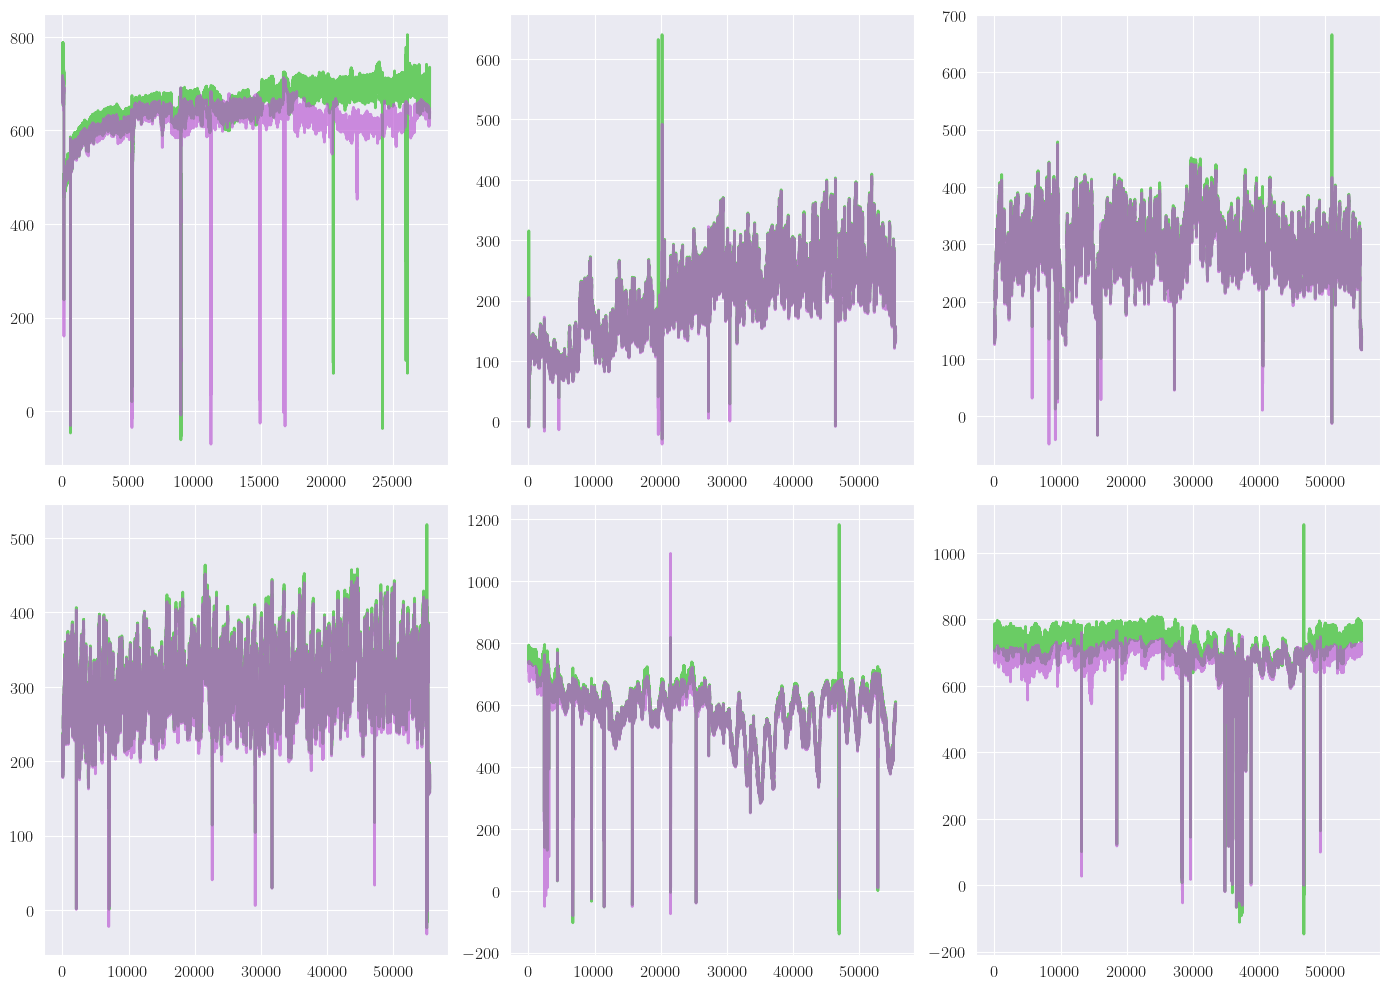

In [20]:
compare_results('/Volumes/T7/ING71_MEC_230310/AVI')

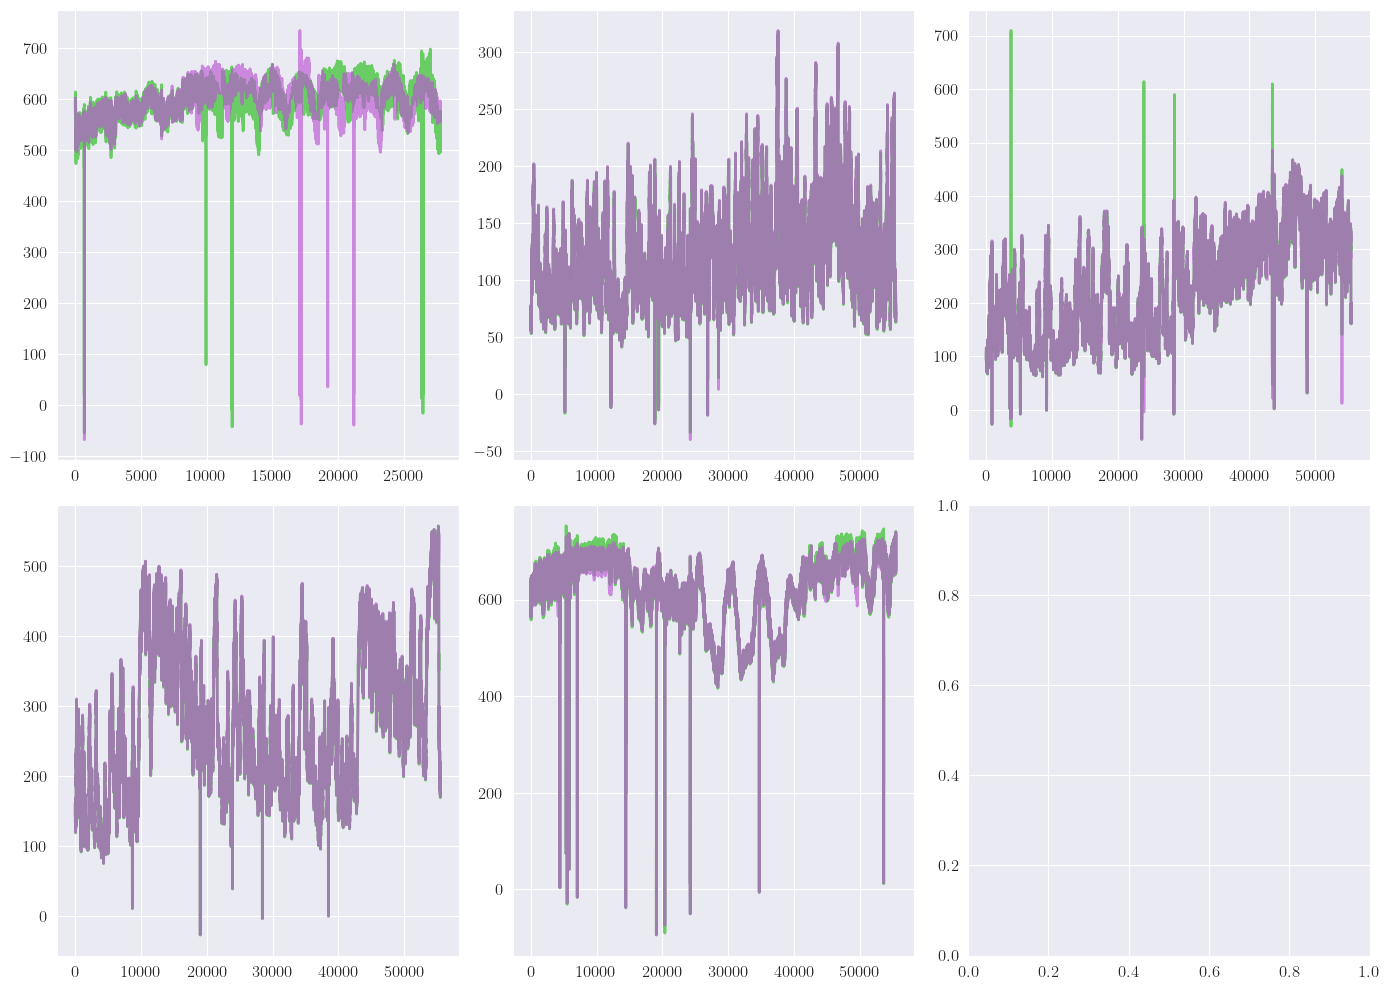

In [7]:
compare_results('/Volumes/T7/ING71_MEC_230309/AVI')

### Filename

In [ ]:
def overwrite_filenames(result_folder, avi_folder=None):
    """
    Takes in a resultfolder (full of npy-files) and overwrites the 'filenames' and 'save_path' so that the procs contain the correct file-path and can be evaluated in the gui. 

    eg. results_folder: '/Volumes/T7/ING71_MEC_230310/AVI/resultsnpy' 
    results_folder is the same as save_path

    filenames requires the avi file corresponding to the npy-file.
    """

    #set avi_folder to the folder "above" result_folder:
    # Simply removing the /resultsnpy (seems too specific, but)
    if avi_folder == None:
        avi_folder = result_folder[:-11]


    files = os.listdir(result_folder)
    clean_files = []

    #Checks for .avi files and catches exception if filenames are shorter than 4 letters.
    for file in files:
        try:
            if file[-4:] == ".npy":
                clean_files.append(file)
        except:
            print('Invalid file name')

    for filename in clean_files:
        npy_path = os.path.join(result_folder, filename)
        proc = np.load(npy_path, allow_pickle=True).item() 

        avi_filename = filename[:-9] + '.avi'
        avi_path = os.path.join(avi_folder, avi_filename)

        #Overwrite:
        proc['filenames'] = [[avi_path]]
        proc['save_path'] = result_folder

        np.save(npy_path, proc)

In [ ]:
overwrite_filenames('/Volumes/T7/ING71_MEC_230310/AVI/resultsnpy')

In [ ]:
# Compare the two procs 

proc_09 = np.load('/Volumes/T7/ING71_MEC_230309/AVI/resultsnpy/ING71_MEC_230309_000_Behav_Fr1-9973_proc.npy', allow_pickle=True).item()
proc_10 = np.load('/Volumes/T7/ING71_MEC_230310/AVI/resultsnpy/ING71_MEC_230310_000_Behav_Fr1-9973_proc.npy', allow_pickle=True).item()

In [ ]:
print(proc_09['filenames'])
print(proc_10['filenames'])

In [ ]:
print(proc_09['save_path'])
print(proc_10['save_path'])

In [ ]:
overwrite_filenames('/Volumes/T7/ING71_MEC_230313/AVI/resultsnpy')

#### For sample file
It would be cool to be able to test the sample-file on several avi-files before processing. However, that would mean preprocessing it before every load :/ Minght not be smooth enough, and we could maybe just process it and then check. 

In [ ]:
proc_sample = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_sample.npy', allow_pickle=True).item()
print(proc_sample['filenames'], proc_sample['save_path'])